# Identifying CpG islands in long stretch of Human DNA

## Primary Authors:
- Go, Daphne Janelyn
- Gilo, Joshua
- Lasala, Kyle Carlo

## Objectives: 
1. Implement an HMM to identify CpG islands in a stretch of human genome sequence
2. Compare the obtained CpG islands against other functional annotations

In this notebook, we will focus only for ***chromosomes 18 (chr18) and 19 (chr19)***. To do this, we must download the transcript sequences of the [human from the Gencode website](https://www.gencodegenes.org/human/) in *fasta* format. Then, we will filter the transcript sequences to chr18 and chr19 only. 

Since we want to create an HMM to identify CpG islands, we must have some reference to build the HMM. In this case, chr18 will be the reference to build the HMM, and chr19 will be the test. We must then download the annotations which is available from this [website](https://genome.ucsc.edu/cgi-bin/hgTables).

#### TODO: insert here why we need to filter out the telomeres and centromeres

## Prerequisites: Downloading the necessary data and importing the libraries.

#### 1. Transcript sequences of human
- Download the transcript sequences in fasta format through this [link](https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_48/gencode.v48.annotation.gtf.gz).
- Extract the compressed file.
- Save the `.fa` file in the same directory to this notebook.
#### 2. CpG annotations of chr18
- Visit this [link](https://genome.ucsc.edu/cgi-bin/hgTables?hgsid=2704278040_OaSFhQdDeBEVFapezdB5gB3xi4A8&clade=mammal&org=Human&db=hg38&hgta_group=regulation&hgta_track=knownGene&hgta_table=0&hgta_regionType=range&position=chr18%3A1-80%2C373%2C285&hgta_outputType=primaryTable&hgta_outFileName=chr18_cpg.csv) to download the CpG annotations for chr18.
- In the `Retrieve and display data` section, click `Get Output`.
- Create a folder in the same directory to this notebook and name it as `chr18`. This will be the folder to store all necessary annotations for chr18.
- Put the downloaded file to the created `chr18` folder.
- Rename the file to `cpg.csv`.
#### 3. CpG annotations of chr19
- Visit this [link](https://genome.ucsc.edu/cgi-bin/hgTables?hgsid=2704300444_QgqWfKbdKoFV0vuiiN7MuzCQzc7y&clade=mammal&org=Human&db=hg38&hgta_group=regulation&hgta_track=crossTissueMapsTissueCellType&hgta_table=0&hgta_regionType=range&position=chr19%3A1-58%2C617%2C616&hgta_outputType=primaryTable&hgta_outFileName=chr19_cpg.csv) to download the CpG annotations .for chr19.
- In the `Retrieve and display data` section, click `Get Output`
- Create a folder in the same directory to this notebook and name it as `chr19`. This will be the folder to store all necessary annotations for chr19.
- Put the downloaded file to the created `chr19` folder.
- Rename the file to `cpg.csv`.
#### 4. Telomeres annotations of chr18
- TODO: ASK HOW TO FIND TELOMERES
#### 5. Telomeres annotations of chr19
- TODO: ASK HOW TO FIND TELOMERES
#### 6. Centromeres annotations of chr18
- Visit this [link](https://genome.ucsc.edu/cgi-bin/hgTables?hgsid=2704300444_QgqWfKbdKoFV0vuiiN7MuzCQzc7y&clade=mammal&org=Human&db=hg38&hgta_group=map&hgta_track=centromeres&hgta_table=0&hgta_regionType=range&position=chr18%3A1-58%2C617%2C616&hgta_outputType=primaryTable&hgta_outFileName=chr18_centromeres.csv) to download the centromere annotations for chr18.
- In the `Retrieve and display data` section, click `Get Output`.
- Put the downloaded file in the `chr18` folder.
- Rename the file to `centromeres.csv`.
#### 7. Centromeres annotations of chr19 
- Visit this [link](https://genome.ucsc.edu/cgi-bin/hgTables?hgsid=2704300444_QgqWfKbdKoFV0vuiiN7MuzCQzc7y&clade=mammal&org=Human&db=hg38&hgta_group=map&hgta_track=centromeres&hgta_table=0&hgta_regionType=range&position=chr19%3A1-58%2C617%2C616&hgta_outputType=wigData&hgta_outFileName=chr19_centromeres.csv) to download the centromere annotations for chr19.
- In the `Retrieve and display data` section, click `Get Output`.
- Put the downloaded file in the `chr19` folder.
- Rename the file to `centromeres.csv`.

In [ ]:
!pip install biopython

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   -------------- ------------------------- 1.0/2.8 MB 8.5 MB/s eta 0:00:01
   -------------------------- ------------- 1.8/2.8 MB 3.5 MB/s eta 0:00:01
   ----------------------------- ---------- 2.1/2.8 MB 3.8 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 3.2 MB/s eta 0:00:00


In [1]:
!pip install hmmlearn

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import pandas as pd
import numpy as np
from Bio import SeqIO
from hmmlearn import hmm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

### Read the data and check for overlapping regions

Function that helps read fasta files

In [4]:
def read_fasta(file_path, filter_header=None):
    sequences = ''
    for record in SeqIO.parse(file_path, "fasta"):
        if filter_header and filter_header not in record.id:
            continue
        sequences = record.seq
    return sequences

Function that helps read the annotation files

In [5]:
def read_centro_telo(file_path_centro, file_path_telo, file_path_cpg):
    centro = pd.read_csv(file_path_centro)
    centro.drop('#"bin"', axis=1, inplace=True)
    
    telo = pd.read_csv(file_path_telo)
    telo.drop('#bin', axis=1, inplace=True)
    telo = telo[telo['type'] == 'telomere']
    
    cpg = pd.read_csv(file_path_cpg)
    cpg.drop('#"bin"', axis=1, inplace=True)
    
    return centro, telo, cpg

Function that checks if there is an overlapping telomeres, centromeres, or CpG islands.

In [8]:
def check_overlap(centro, telo, cpg):
    telo.sort_values('chromStart', inplace=True)
    
    start_telo = telo[['chromStart', 'chromEnd']].iloc[0, 1]
    end_telo = telo[['chromStart', 'chromEnd']].iloc[1, 0]

    if len(cpg[cpg['chromStart'] < start_telo]) > 0 or len(cpg[cpg['chromEnd'] > end_telo]) > 0:
        print("There is a CpG island overlapping with Telomeric regions.")
    else:
        print("There is NO overlapping CpG island with Telomeric regions.")
        
    centro.sort_values('chromStart', inplace=True)
    min_centro = centro[['chromStart','chromEnd']].iloc[0,0]
    max_centro = centro[['chromStart','chromEnd']].iloc[len(centro)-1, 1]

    if len(cpg[(cpg['chromStart'] > min_centro) & (cpg['chromEnd'] < max_centro)]) > 0:
        print("Do a manual inspection because there is a CpG island in between the Centromeric regions.")
    else:
        print("There is NO overlapping CpG island with Centromeric regions.")

Reads the transcript sequences of chr18 and its corresponding annotations

In [9]:
seq = read_fasta('./GRCh38.p14.genome.fa', 'chr18')
centro18_df, telo18_df, cpg18_df = read_centro_telo('./chr18/centromeres.csv','./chr18/telomeres.csv', './chr18/cpg.csv')

Checks for overlapping regions

In [10]:
check_overlap(centro18_df, telo18_df, cpg18_df)

There is NO overlapping CpG island with Telomeric regions.
There is NO overlapping CpG island with Centromeric regions.


### Construct the transition probabilities of HMM using chr18

Function that checks if the current state is in the given region

In [12]:
def check_in_start_end(i, index, start_end, in_):
    if index < len(start_end):
        if not in_ and i >= start_end[index]:
            return True, index + 1
        if in_ and i >= start_end[index]:
            return False, index + 1
    return in_, index    

Linearly traverse the sequence and count each states and transitions

In [13]:
# check regions for ith base
in_cpg = False
cpg_index = 0

in_centro = False
centro_index = 0

in_telo = False
telo_index = 0

# check regions for (i+1)th base
in_cpg_next = False
cpg_index_next = 0

in_centro_next = False
centro_index_next = 0

in_telo_next = False
telo_index_next = 0

# flatten the regions
telo_start_end = telo18_df.sort_values('chromStart')[['chromStart', 'chromEnd']].to_numpy().flatten()
centro_start_end = centro18_df.sort_values('chromStart')[['chromStart', 'chromEnd']].to_numpy().flatten()
cpg_start_end = cpg18_df.sort_values('chromStart')[['chromStart', 'chromEnd']].to_numpy().flatten()

# Format: A-, G-, C-, T-, A+, G+, C+, T+
init = np.zeros(8) # data structure for initial probabilities
tran = np.zeros((8,8)) # data structure for transition probabilities

# base to index
state_index = {
    'A-': 0,
    'G-': 1,
    'C-': 2,
    'T-': 3,
    'A+': 4,
    'G+': 5,
    'C+': 6,
    'T+': 7,
}

# linearly traverse the sequence
for i in range(len(seq)):
    # check if in telomeric region
    in_telo, telo_index = check_in_start_end(i, telo_index, telo_start_end, in_telo)
    if in_telo:
        continue

    # check if in centromeric region
    in_centro, centro_index = check_in_start_end(i, centro_index, centro_start_end, in_centro)
    if in_centro:
        continue

    # check if in CpG island
    in_cpg, cpg_index = check_in_start_end(i, cpg_index, cpg_start_end, in_cpg)

    # avoid ambiguous bases N
    if seq[i] == 'N':
        continue

    # counting the frequency of each Markov States
    base_i = seq[i] + ('+' if in_cpg else '-')
    init[state_index[base_i]] += 1

    if i + 1 < len(seq):
        # check if next index in telomeric region
        in_telo_next, telo_index_next = check_in_start_end(i + 1, telo_index_next, telo_start_end, in_telo_next)
        if in_telo_next:
            continue

        # check if next base in centromeric region
        in_centro_next, centro_index_next = check_in_start_end(i + 1, centro_index_next, centro_start_end, in_centro_next)
        if in_centro_next:
            continue

        # check if next base in CpG island
        in_cpg_next, cpg_index_next = check_in_start_end(i + 1, cpg_index_next, cpg_start_end, in_cpg_next)

        # avoid ambiguous bases N
        if seq[i+1] == 'N':
            continue

        base_i_next = seq[i + 1] + ('+' if in_cpg_next else '-')
        tran[state_index[base_i_next], state_index[base_i]] += 1

Construct the initial probabilities

In [16]:
init_probs = init/init.sum()
init_probs

array([0.29997011, 0.19703748, 0.19670899, 0.30027983, 0.00093958,
       0.00205016, 0.00206689, 0.00094697])

Construct the transition probabilities

In [17]:
tran_probs = tran/tran.sum(axis=1)[:, np.newaxis]
tran_probs

array([[3.36673990e-01, 1.95908309e-01, 2.39228107e-01, 2.28186162e-01,
        0.00000000e+00, 3.43276126e-06, 0.00000000e+00, 0.00000000e+00],
       [3.47248782e-01, 2.44139710e-01, 4.30627657e-02, 3.65536322e-01,
        0.00000000e+00, 1.24203267e-05, 0.00000000e+00, 0.00000000e+00],
       [2.54927379e-01, 2.02469356e-01, 2.44062515e-01, 2.98531777e-01,
        0.00000000e+00, 8.97388884e-06, 0.00000000e+00, 0.00000000e+00],
       [2.67780742e-01, 1.67633343e-01, 2.27956537e-01, 3.36624168e-01,
        0.00000000e+00, 5.21063363e-06, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.99077698e-01, 3.56594885e-01, 3.58744075e-01, 8.55833416e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.89002316e-01, 3.56557190e-01, 2.92117022e-01, 1.62323473e-01],
       [6.34074381e-04, 8.41119077e-04, 1.30696964e-03, 5.11141593e-04,
        1.24278579e-01, 3.47272186e-01, 3.57223272e-01, 1.

Sanity check

In [18]:
# sanity check for initial probabilities
print("Total should be 1")
print(init_probs.sum())
# sanity check for transition probabilities
print("All elements must total to 1")
print(tran_probs.sum(axis=1))

Total should be 1
1.0
All elements must total to 1
[1. 1. 1. 1. 1. 1. 1. 1.]


Checkpoint

In [20]:
# Checkpoint for transition probabilities
np.savetxt("transition_probs.csv", tran_probs, delimiter=",")
# Checkpoint for initial probabilities
np.savetxt("initial_probs.csv", init_probs, delimiter=",")

### Extract regions of chr19 WITHOUT telomere and centromere

Function that checks if the current state is in the given region

In [22]:
def check_in_start_end(i, index, start_end, in_):
    if index < len(start_end):
        if not in_ and i >= start_end[index]:
            return True, index + 1
        if in_ and i >= start_end[index]:
            return False, index + 1
    return in_, index    

Function that searches for first index without ambiguous base N

In [26]:
def find_first_valid_index(seq):
    for i, base in enumerate(seq):
        if base != 'N':
            return i
    return -1

Function that searches for first index with N

In [27]:
def find_first_invalid_index(seq):
    for i, base in enumerate(seq):
        if base == 'N':
            return i
    return -1

Function that finds a subsequence such that
- end of first telomere region- start of first centromere region
- skip all centromere regions 
- end of last centromere - start of second/last telomere region

A telomere is a region of repetitive DNA sequences at the end of a chromosome. Both chr18 and chr19 have only two telomere regions.

In [28]:
def find_valid_subsequence(seq):
    start_index = find_first_valid_index(seq)
    if start_index == -1:
        return 0, 0, ''

    end_index = find_first_invalid_index(seq[start_index:])
    if end_index == -1:
        return start_index, len(seq), seq[start_index:]

    end_index += start_index
    return start_index, end_index, seq[start_index:end_index]

Reads the transcript sequences of chr19 and its corresponding annotations

In [23]:
seq_test = read_fasta('./GRCh38.p14.genome.fa', 'chr19')
centro19_df, telo19_df, cpg19_df = read_centro_telo('./chr19/centromeres.csv','./chr19/telomeres.csv', './chr19/cpg.csv')

Check for overlapping regions

In [24]:
check_overlap(centro19_df, telo19_df, cpg19_df)

There is NO overlapping CpG island with Telomeric regions.
There is NO overlapping CpG island with Centromeric regions.


Extract 2 subsequences from chr19 

In [29]:
# Extract start of the first centromere and end of last centromere
start_centro = centro19_df['chromStart'][0]
end_centro = centro19_df['chromEnd'].iloc[-1]

# Extract end of the first telomere and start of the last telomere
end_first_telo = telo19_df['chromEnd'].iloc[0]
start_last_telo = telo19_df['chromStart'].iloc[-1]

# Extract 2 subsequences 
seq_test_1 = seq_test[end_first_telo: start_centro] # end of first telomere until start of first centromere
seq_test_2 = seq_test[end_centro: start_last_telo]  # end of last centromere until start of last telomere

Checkpoint

In [30]:
start_index_1, end_index_1, valid_subsequence_1 = find_valid_subsequence(seq_test_1)
start_index_2, end_index_2, valid_subsequence_2 = find_valid_subsequence(seq_test_2)

with open('seq_test_1_withoutN.fasta', 'w') as f:
    f.write(f'>seq_test_1_withoutN\tindex {end_first_telo + start_index_1}:{end_first_telo+ end_index_1}\n{valid_subsequence_1}\n')
with open('seq_test_2_withoutN.fasta', 'w') as f:
    f.write(f'>seq_test_2_withoutN\tindex {end_centro + start_index_2}:{end_centro+ end_index_2}\n{valid_subsequence_2}\n')

### Build HMM

In [4]:
states = ['A-', 'G-', 'C-', 'T-', 'A+', 'G+', 'C+', 'T+']
n_states = len(states)

In [5]:
transition_probs = np.loadtxt("transition_probs.csv", delimiter=",")
initial_probs = np.loadtxt("initial_probs.csv", delimiter=",")
emit_probs = np.concatenate([np.eye(4), np.eye(4)])

In [6]:
model = hmm.CategoricalHMM(n_components=n_states, verbose=True)
model.startprob_= initial_probs
model.emissionprob_ = emit_probs
model.transmat_ = transition_probs

### Decode using the HMM

Function that converts letters into numbers and stores into a numpy array

In [11]:
def get_gene_sequence(filename):
    file = read_fasta(filename)
    gene = str(file)            
    out = []
    
    for char in gene :
        if char == "A":
            out.append([0])
        elif char == "G":
            out.append([1])
        elif char == "C":
            out.append([2])
        else:
            out.append([3])
            
    return np.array(out)

Reads the selected stretches of chr19

In [5]:
test_sequence_np_1 = get_gene_sequence("seq_test_1_withoutN.fasta")

In [6]:
test_sequence_np_2 = get_gene_sequence("seq_test_2_withoutN.fasta")

Decode using Viterbi Algorithm

In [13]:
logprob_1_vit, output_bases_1_vit = model.decode(test_sequence_np_1, algorithm="viterbi")
out_1_vit = "%s"%" ".join([states[x][-1] for x in output_bases_1_vit])

In [14]:
logprob_2_vit, output_bases_2_vit = model.decode(test_sequence_np_2, algorithm="viterbi")
out_2_vit = "%s"%" ".join([states[x][-1] for x in output_bases_2_vit])

Decode using Posterior Algorithm

In [15]:
logprob_1_pos, output_bases_1_pos = model.decode(test_sequence_np_1, algorithm="map")
out_1_pos = "%s"%" ".join([states[x][-1] for x in output_bases_1_pos])

In [16]:
logprob_2_pos, output_bases_2_pos = model.decode(test_sequence_np_2, algorithm="map")
out_2_pos = "%s"%" ".join([states[x][-1] for x in output_bases_2_pos])

Checkpoint

In [17]:
# Viterbi outputs
with open ("output_1_vit.txt", "w") as f:
    f.write(out_1_vit)
with open ("output_2_vit.txt", "w") as f:
    f.write(out_2_vit)

In [18]:
# Posterior outputs
with open ("output_1_pos.txt", "w") as f:
    f.write(out_1_pos)

with open ("output_2_pos.txt", "w") as f:
    f.write(out_2_pos)

### HMM Evaluation

Read the CpG annotation of chr19

In [6]:
_, _, cpg19_df = read_centro_telo('./chr19/centromeres.csv','./chr19/telomeres.csv', './chr19/cpg.csv')
cpg_start_end = cpg19_df.sort_values('chromStart')[['chromStart', 'chromEnd']].to_numpy().flatten()

Extract start and end indices of the two test subsequences for chr19

In [7]:
def extract_header(filepath):
    seq = next (SeqIO.parse(filepath, "fasta"))
    header = seq.description
    index_field = header.split("\t")[1]
    range_index = index_field.split()[1]
    start_index = int(range_index.split(":")[0])
    end_index = int(range_index.split(":")[1])
    # remove seq from memory
    del seq
    return start_index, end_index

In [8]:
# read fasta using seqio
start_index_1, end_index_1 = extract_header("seq_test_1_withoutN.fasta")
print(f"Start index 1: {start_index_1}, End index 1: {end_index_1}")

start_index_2, end_index_2 = extract_header("seq_test_2_withoutN.fasta")
print(f"Start index 2: {start_index_2}, End index 2: {end_index_2}")


Start index 1: 60000, End index 1: 24448980
Start index 2: 27240874, End index 2: 58607616


Annotate the two subsequences as ground truth data (+ for CpG island and - for non-CpG island)

In [9]:
def get_ground_truth(start_index, end_index, cpg_start_end):
    ground_truth = []
    starting_region = '-'

    # determine if the start index is in a non-CpG or CpG island
    for i, each in enumerate(cpg_start_end):
        if start_index < each:
            if i % 2:
                starting_region = '+'
            break
            
    # [starting_region, opposite]
    annot = [starting_region, '-' if starting_region == '+' else '+']
    
    # generate the ground truth
    for j, k in enumerate(cpg_start_end[i:]):
        if j == 0:
            ground_truth = np.full(each-start_index, starting_region)
        else:
            if k > end_index:
                ground_truth = np.append(ground_truth, np.full(end_index-cpg_start_end[j-1], annot[j % 2]))
                break
            else:
                ground_truth = np.append(ground_truth, np.full(k-cpg_start_end[j-1], annot[j % 2]))
    return ground_truth, annot

def get_performance_metrics(confusion_mat):
    TN, FP = confusion_mat[0]
    FN, TP = confusion_mat[1]
    
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Accuracy: {accuracy:.2f}")

In [ ]:
ground_truth_1, annot_1 = get_ground_truth(start_index_1, end_index_1, cpg_start_end)
ground_truth_2, annot_2= get_ground_truth(start_index_2, end_index_2, cpg_start_end)
ground_truth = np.concatenate((ground_truth_1, ground_truth_2))

In [10]:
ground_truth_1, annot_1 = get_ground_truth(start_index_1, end_index_1, cpg_start_end)

In [ ]:
ground_truth_2, annot_2= get_ground_truth(start_index_2, end_index_2, cpg_start_end)

#### Viterbi Algorithm

Read the outputs of HMM model to the selected stretches of chr19 using Viterbi

In [11]:
output_1_vit = np.loadtxt("output_1_vit.txt", delimiter=" ", dtype=str)
output_2_vit = np.loadtxt("output_2_vit.txt", delimiter=" ", dtype=str)

Obtain and plot confusion matrices, one for each subsequence, and one combined.

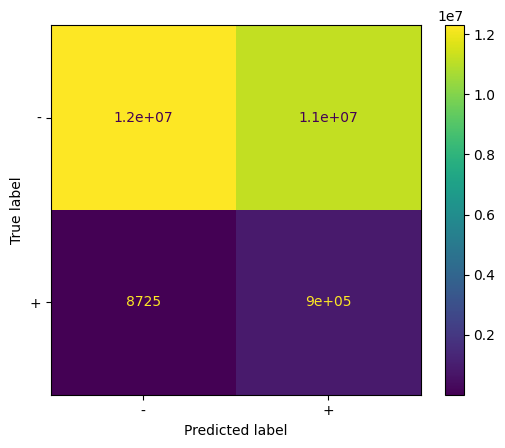

In [12]:
confusion_mat_1_vit = confusion_matrix(ground_truth_1, output_1_vit, labels=annot_1)
disp_1_vit = ConfusionMatrixDisplay(confusion_matrix=confusion_mat_1_vit, display_labels=annot_1)
disp_1_vit.plot()
plt.show()

In [ ]:
confusion_mat_2_vit = confusion_matrix(ground_truth_2, output_2_vit, labels=annot_2)
disp_2_vit = ConfusionMatrixDisplay(confusion_matrix=confusion_mat_2_vit, display_labels=annot_2)
disp_2_vit.plot()
plt.show()

In [ ]:
output_vit = np.concatenate((output_1_vit, output_2_vit))
confusion_mat_vit = confusion_matrix(ground_truth, output_vit, labels=annot_1)
disp_vit = ConfusionMatrixDisplay(confusion_matrix=confusion_mat_vit, display_labels=annot_1)
disp_vit.plot()
plt.show()

In [ ]:
print ("Performance Metrics for Viterbi Outputs:")
print ("Sequence 1:")
get_performance_metrics(confusion_mat_1_vit)
print ("Sequence 2:")
get_performance_metrics(confusion_mat_2_vit)
print ("Combined Performance Metrics:")
get_performance_metrics(confusion_mat_vit)

Precision: 0.07
Recall: 0.99
Accuracy: 0.54


#### Posterior Algorithm

Read the outputs of HMM model to the selected stretches of chr19 using Posterior

In [13]:
output_1_pos = np.loadtxt("output_1_pos.txt", delimiter=" ", dtype=str)
output_2_pos = np.loadtxt("output_2_pos.txt", delimiter=" ", dtype=str)

Obtain and plot confusion matrices, one for each subsequence, and one combined.

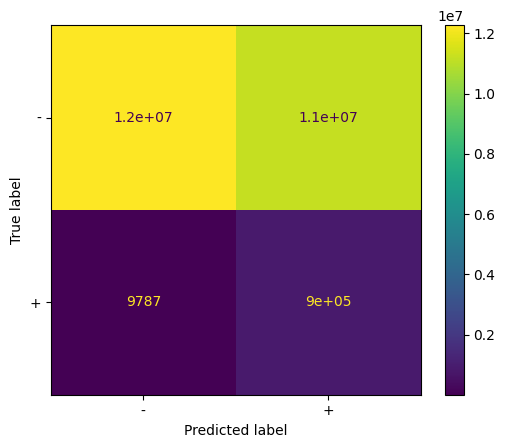

In [14]:
confusion_mat_1_pos = confusion_matrix(ground_truth_1, output_1_pos, labels=annot_1)
disp_1_pos = ConfusionMatrixDisplay(confusion_matrix=confusion_mat_1_pos, display_labels=annot_1)
disp_1_pos.plot()
plt.show()

In [ ]:
confusion_mat_2_pos = confusion_matrix(ground_truth_2, output_2_pos, labels=annot_2)
disp_2_pos = ConfusionMatrixDisplay(confusion_matrix=confusion_mat_2_pos, display_labels=annot_2)
disp_2_pos.plot()
plt.show()

In [ ]:
output_pos = np.concatenate((output_1_pos, output_2_pos))
confusion_mat_pos = confusion_matrix(ground_truth, output_pos, labels=annot_1)
disp_pos = ConfusionMatrixDisplay(confusion_matrix=confusion_mat_pos, display_labels=annot_1)
disp_pos.plot()
plt.show()

In [ ]:
print ("Performance Metrics for Posterior Outputs:")
print ("Sequence 1:")
get_performance_metrics(confusion_mat_1_pos)
print ("Sequence 2:")
get_performance_metrics(confusion_mat_2_pos)
print ("Combined Performance Metrics:")
get_performance_metrics(confusion_mat_pos)